# Task 8

Compare approximation with Laplace approximation, Variational inference and Expectation propagation for:
- Gaussian mixture (visualize for different parameters of mixture)
- Beta-distribution with a and beta < 1 (visualize for different parameters)

In [ ]:
import jax
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import jax.numpy as jnp
import jax.scipy as jsp
from scipy.optimize import fsolve
from scipy.misc import derivative
from jax import jit, grad, random, vmap

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Обзор распределений

### Gaussian mixture

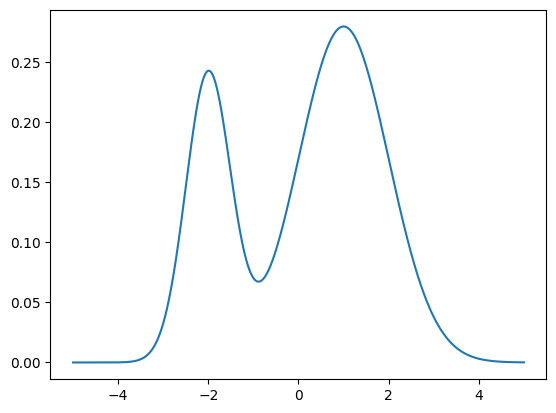

In [ ]:
def gaus_mix(x, alpha=0.5, mu1=0, mu2=0, sigma1=1, sigma2=1):
    norm1 = st.norm.pdf(x, loc=mu1, scale=sigma1)
    norm2 = st.norm.pdf(x, loc=mu2, scale=sigma2)
    return alpha * norm1 + (1-alpha) * norm2

x = np.linspace(-5, 5, 1000)
y = gaus_mix(x, 0.3, -2, 1, 0.5, 1)

plt.plot(x, y)
plt.show()

### Beta dist

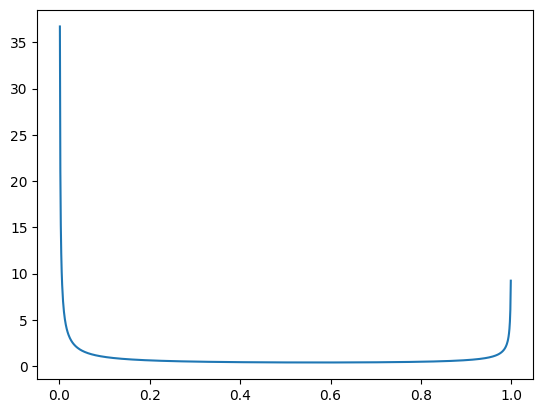

In [ ]:
x = np.linspace(0, 1, 1000)
y = st.beta.pdf(x, a=0.2, b=0.4)

plt.plot(x, y)
plt.show()

## Реализция методов

### Laplas

Суть аппроксимации: </br>
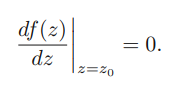 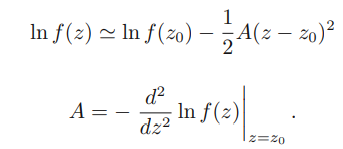
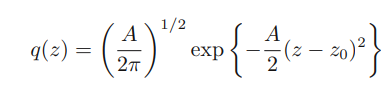

In [ ]:
from scipy.optimize import minimize

class Laplas():
    def __init__(self, f):
        minus_f = lambda x: -f(x)
        # z0 должна быть точкой максимума
        z0 = minimize(minus_f, 0).x[0]
        log_f = lambda x: np.log(f(x))
        a = -derivative(log_f, z0, n=2, dx=1e-6)
        self.q = lambda z: np.sqrt(a / (2 * np.pi)) * np.exp(- a / 2 * np.power(z-z0, 2))

    def __call__(self, x):
        return self.q(x)

###  Variational inference

Вкратце суть метода: минимизировать KL-дивергенцию от q до p

In [ ]:
from scipy.integrate import quad
from scipy.optimize import minimize

class VarInf():
    def __init__(self, f, left=-10, right=10):
        # Интеграл будем считать приближенно на интервале [-10, 10]
        self.left = left
        self.right = right
        self.f = f

        # Подбор параметров
        x0 = [0, 1]
        res = minimize(self.kl_div, x0, method='SLSQP')
        mu, sigma = res.x
        self.mu = mu
        self.sigma = sigma

    def integral(self, f):
        return quad(f, self.left, self.right)[0]

    def q(self, x, mu, sigma):
        return st.norm.pdf(x, loc=mu, scale=sigma)

    def kl_div(self, params):
        q = lambda x: self.q(x, params[0], params[1])
        func = lambda x: q(x) * np.log(self.f(x) / q(x) + 1e-15)
        return -self.integral(func)

    def __call__(self, x):
        return self.q(x, self.mu, self.sigma)

### Expectation propagation

А тут нужно минимизировать KL-дивергенцию уже от p до q. </br>
В книге сказано, что в этом случае коэффициенты равны: mu = E[X], sigma^2 = D[X]

In [ ]:
class ExpProp():
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def __call__(self, x):
        return 1 / (self.sigma * np.sqrt(2 * np.pi)) * np.exp(-np.power(x - self.mu, 2) / (2 * np.power(self.sigma, 2)))


## Тестирование

**Чтобы проверить, что функции работают правильно, сделаем аппроксимации для модельного примера из учебника и сравним результаты**

In [ ]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
f = lambda x: np.exp(-np.power(x, 2) / 2) * sigmoid(20 * x + 4)

Найдем коэффициент для нормировки, так как эта функция изначально не нормирована

In [ ]:
c = quad(f, -20, 20)[0]
c

1.451189367558708

In [ ]:
from scipy.stats import rv_continuous

# Класс для подсчета матожидания и дисперсии
class Func(rv_continuous):
    def _pdf(self, x):
        return f(x) / c

In [ ]:
func = Func()
mu = func.expect()
mu

0.6728003095350346

In [ ]:
sigma = func.std()
sigma

0.6433289721596122

In [ ]:
x = np.linspace(-2, 4, 1000)

real = func._pdf(x)

laplas_f = Laplas(func._pdf)
laplas = laplas_f(x)

var_inf_f = VarInf(func._pdf)
var_inf = var_inf_f(x)

exp_prop_f = ExpProp(mu, sigma)
exp_prop = exp_prop_f(x)

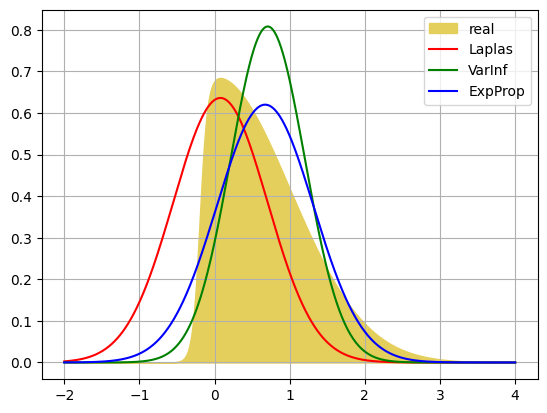

In [ ]:
plt.fill_between(x, real, np.zeros(len(real)), label="real", color="#e5cf5c")
plt.plot(x, laplas, label="Laplas", color="red")
plt.plot(x, var_inf, label="VarInf", color="green")
plt.plot(x, exp_prop, label="ExpProp", color="blue")
plt.grid()
plt.legend()

plt.show()

**Из учебника:** </br>
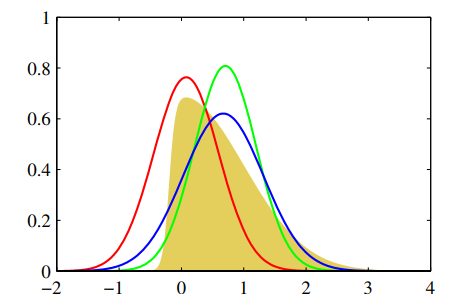
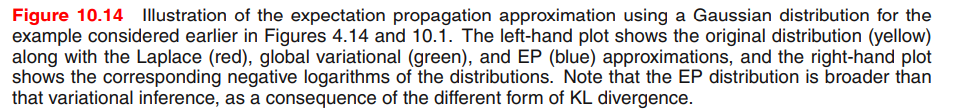

Для всех распределений, кроме Лапласа, графики получились такими же. В учебнике не было подробного описания, как была получена кривая для Лапласа, поэтому возможны расхождения.

Чтобы убедиться, что мой метод работает правильно, возьмем реализацию аппроксимации с гитхаба и сравним с моей.

In [ ]:
# !git clone https://github.com/lmc2179/laplace_approximation_dist

In [ ]:
# ! pip install numdifftools

In [ ]:
from laplace_approximation_dist.laplace_approximation_dist.approx import approx_dist

In [ ]:
logpdf = lambda x: np.log(func._pdf(x))
result = approx_dist(logpdf, 0)

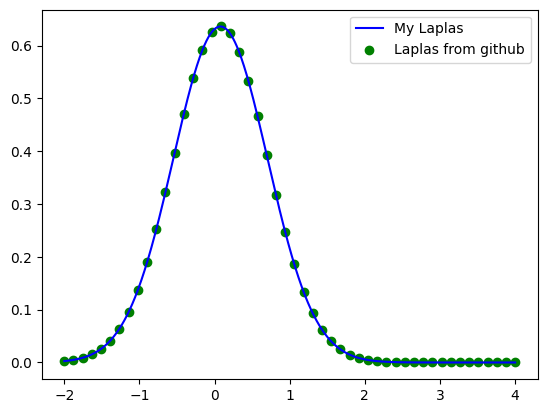

In [ ]:
plt.plot(x, laplas, label="My Laplas", color="blue")
point_x = np.linspace(-2, 4, 50)
plt.scatter(point_x, result.pdf(point_x), label="Laplas from github", color="green")
plt.legend()
plt.show()

Получились одинаковые распределения, а значит моя реализация аппроксимации Лапласа - верная.

## Применение аппроксимаций для Gaussian mixture

Возьмем несколько вариантов параметров и визуализируем. Делать интерактивные графики особо смылса нет, так как для построения нужно ждать сходимости в функциях. Поэтому проще просто забить свои параметры в grid

In [ ]:
grid = [
    {
        "alpha": 0.2,
        "mu1": -1,
        "mu2": 2,
        "sigma1": 1,
        "sigma2": 0.5
    },
    {
        "alpha": 0.8,
        "mu1": -1,
        "mu2": 2,
        "sigma1": 1,
        "sigma2": 1
    },
    {
        "alpha": 0.45,
        "mu1": 0,
        "mu2": 1,
        "sigma1": 1,
        "sigma2": 0.3
    }
]

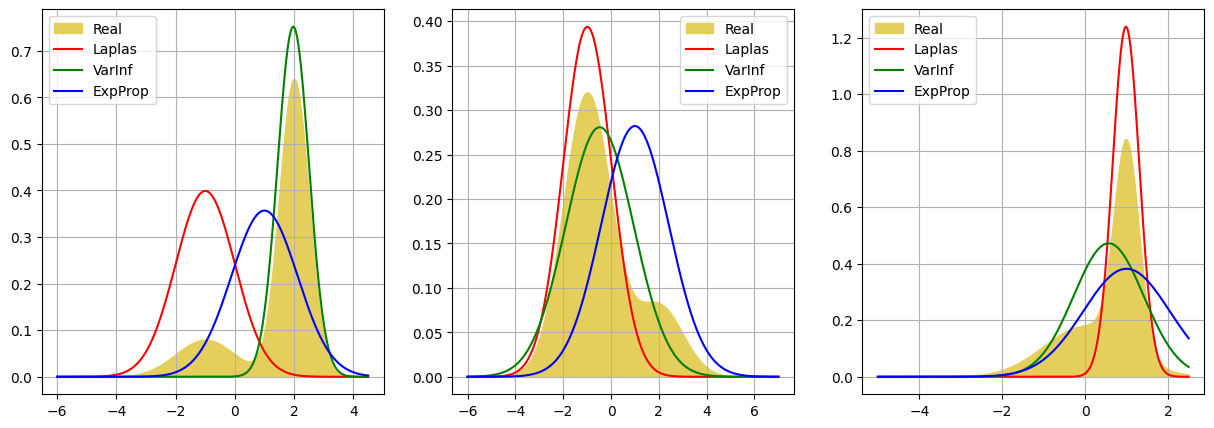

In [ ]:
fig, axes = plt.subplots(1, len(grid), figsize=(5 * len(grid), 5))

for i, params in enumerate(grid):
    func = lambda x: gaus_mix(x, **params)
    left = params["mu1"] - 5 * params["sigma1"]
    right = params["mu2"] + 5 * params["sigma2"]

    x = np.linspace(left, right, 1000)

    laplas_f = Laplas(func)
    laplas = laplas_f(x)

    var_inf_f = VarInf(func, left, right)
    var_inf = var_inf_f(x)

    mu = params["mu1"] + params["mu2"]
    sigma = np.hypot(params["sigma1"], params["sigma2"])

    exp_prop_f = ExpProp(mu, sigma)
    exp_prop = exp_prop_f(x)

    ax = axes[i]
    ax.fill_between(x, func(x), label="Real", color="#e5cf5c")
    ax.plot(x, laplas, label="Laplas", color="red")
    ax.plot(x, var_inf, label="VarInf", color="green")
    ax.plot(x, exp_prop, label="ExpProp", color="blue")
    ax.grid()
    ax.legend()

**Все аппроксимации дольно неплохие**

## Применение аппроксимаций для Beta distribution

In [ ]:
grid = [
    {
        "a": 0.2,
        "b": 0.8
    },
    {
        "a": 0.4,
        "b": 0.8
    },
    {
        "a": 0.5,
        "b": 0.5
    }
]

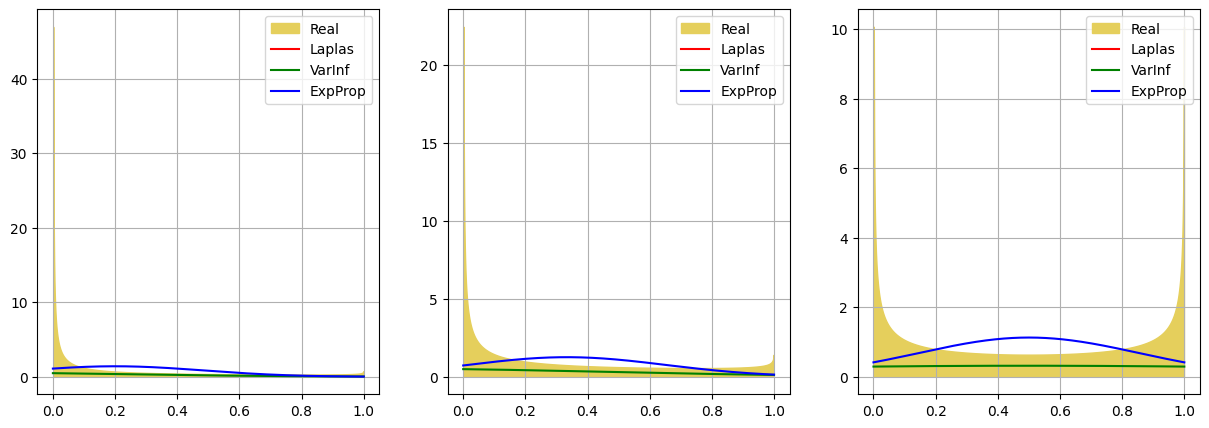

In [ ]:
fig, axes = plt.subplots(1, len(grid), figsize=(5 * len(grid), 5))

for i, params in enumerate(grid):
    func = lambda x: st.beta.pdf(x, **params)
    left = 0
    right = 1

    x = np.linspace(left, right, 1000)

    laplas_f = Laplas(func)
    laplas = laplas_f(x)

    var_inf_f = VarInf(func, left, right)
    var_inf = var_inf_f(x)

    a = params["a"]
    b = params["b"]
    mu = a / (a + b)
    sigma = np.sqrt((a * b) / (a + b + 1)) / (a + b)

    exp_prop_f = ExpProp(mu, sigma)
    exp_prop = exp_prop_f(x)

    ax = axes[i]
    ax.fill_between(x, func(x), label="Real", color="#e5cf5c")
    ax.plot(x, laplas, label="Laplas", color="red")
    ax.plot(x, var_inf, label="VarInf", color="green")
    ax.plot(x, exp_prop, label="ExpProp", color="blue")
    ax.grid()
    ax.legend()

**Здесь не построилась аппроксимация Лапласа, так как тут точка максимума лежит в 0 или 1, а функция в ней равна бесконечности. Поэтому алгоритм не может вычислить z0. Это недостаток метода Лапласа - он строит аппроксимация около моды распределения. А тут на интервале (0, 1) при a, b < 1 ее нету.**

Также выдно что эти аппроксимации не особо подходят для данного распределения. Так как они все являются вогнутыми функциями, а бета распределение - это выпуклая функция.